In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import signal
from scipy.signal import butter, filtfilt, find_peaks,welch

import pywt
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 原始数据

In [2]:
sampling_rate = 128  # 手腕ppg采样率，Hz
data = np.load(r'D:\D盘\已总结完—数据分析学习总结\20250414整理数据分析面试资料\kaggle\心率检测项目\心率估算-kaggle\24-exercise1\mhealth24_data_public.npy', allow_pickle=True).item() 
phase0_data = data['phase 0']
print('Keys for phase 0:', phase0_data.keys())

ppg_phase0 = phase0_data['PPG wrist']
ref_hr_phase0 = phase0_data['ground truth HR']  # 仅对 for phase 0, 2, ，4 (训练集)
IMU_X_phase0 = phase0_data['IMU X wrist']
IMU_Y_phase0 = phase0_data['IMU Y wrist']
IMU_Z_phase0 = phase0_data['IMU Z wrist']

Keys for phase 0: dict_keys(['ground truth HR', 'PPG wrist', 'IMU X wrist', 'IMU Y wrist', 'IMU Z wrist'])


## 数据处理

In [6]:
class PPGProcessor:
    """PPG信号处理"""
    
    def __init__(self, fs=128):
        """
        初始化处理器
        fs: 采样频率(Hz)
        """
        self.fs = fs

#     使用0.1Hz高通滤波去直流、去除极端基线漂移
 # 评估去直流和去除极端基线漂移的效果
#    （1）直流分量：处理后的信号均值应接近0。
#    （2）低频成分：计算处理前后信号的功率谱密度，检查0.1Hz以下的功率是否被有效抑制。
#    （3）信号波形：观察时域波形，看是否去除了缓慢变化的基线漂移，同时保留心率的波动。

    def preprocess_ppg(self, raw_signal):
        """
        初步预处理：去直流、去除极端基线漂移
        使用0.1Hz高通滤波去除极端基线漂移
        """
        # 1. 去直流
        processed_signal = raw_signal - np.mean(raw_signal)
        
        # 2. 0.1Hz高通滤波去除极端基线漂移
        nyquist = 0.5 * self.fs
        high_cut = 0.1 / nyquist
        
        # 使用二阶巴特沃兹高通滤波器
        b, a = butter(2, high_cut, btype='high')
        ppg_highpassed = filtfilt(b, a, processed_signal)
        
        # 指标评价
        metrics = {}
        # 1、直流分量去除效果，eva_mean越接近0越好
        raw_dc = np.mean(raw_signal)
        proc_dc = np.mean(processed_signal)
        metrics['eva_mean'] = round(proc_dc,2)
        metrics['dc_removal'] = round(np.abs(proc_dc) / (np.abs(raw_dc) + 1e-10),2)
        
        # 2. 基线稳定性评估
        # 计算信号的慢变成分（0.1Hz以下）
        nyquist = 0.5 * self.fs
        b_low, a_low = butter(2, 0.1/nyquist, btype='low')
        baseline_raw = filtfilt(b_low, a_low, raw_signal)
        baseline_proc = filtfilt(b_low, a_low, ppg_highpassed)
        
        # 基线波动幅度
        baseline_amp_raw = np.std(baseline_raw)
        baseline_amp_proc = np.std(baseline_proc)
        metrics['baseline_reduction'] = round(baseline_amp_proc / (baseline_amp_raw + 1e-10),2)
        
        # 3. 信号功率保留率
#         通常用信号的方差来估计信号的功率，
        power_raw = np.var(raw_signal)
        power_proc = np.var(ppg_highpassed)
        metrics['power_preservation'] = round(power_proc / (power_raw + 1e-10),2)
        # 该比例值越接近1越好，如果这个值远小于1，说明信号可能被过度平滑或衰减；如果远大于1，说明可能引入了噪声。
        
        # 4. 高频成分保护
        b_high, a_high = butter(2, 0.5/nyquist, btype='high')
        hf_raw = filtfilt(b_high, a_high, raw_signal)
        hf_proc = filtfilt(b_high, a_high, ppg_highpassed)
        hf_power_raw = np.var(hf_raw)
        hf_power_proc = np.var(hf_proc)
        metrics['hf_preservation'] = round(hf_power_proc / (hf_power_raw + 1e-10),2)

        return ppg_highpassed,metrics

    # 预处理加速度计信号
    def preprocess_accel(self, accel_x, accel_y, accel_z):
        """
        预处理加速度计信号
        """
        # 去直流
        accel_x_dc = accel_x - np.mean(accel_x)
        accel_y_dc = accel_y - np.mean(accel_y)
        accel_z_dc = accel_z - np.mean(accel_z)
        
        # 可选的0.5-20Hz带通滤波，保留可能包含运动伪影的频带
        nyquist = 0.5 * self.fs
        low = 0.5 / nyquist
        high = 20.0 / nyquist
        
        b, a = butter(2, [low, high], btype='band')
        accel_x_filt = filtfilt(b, a, accel_x_dc)
        accel_y_filt = filtfilt(b, a, accel_y_dc)
        accel_z_filt = filtfilt(b, a, accel_z_dc)
        
        return accel_x_filt, accel_y_filt, accel_z_filt
    
    # 归一化最小均方(NLMS)自适应滤波器去除运动伪影
    def multi_channel_nlms(self, ppg, accel_x, accel_y, accel_z, filter_order=16, mu=0.005):
        """
        多通道NLMS自适应滤波器
        使用三轴加速度计作为参考信号
        
        Args:
            ppg: PPG信号
            accel_x, accel_y, accel_z: 三轴加速度计信号
            filter_order: 每个通道的滤波器阶数
            mu: 步长参数
            滤波器阶数filter_order决定了每个滤波器使用过去多少个采样点的加速度计信号来估计当前的运动伪影。
            阶数越高，能够建模的运动伪影与加速度计信号的关系越复杂，但计算量也越大，且可能过拟合。
            步长参数mu控制了权重更新的速度。mu太大可能导致算法不稳定，太小则收敛慢。
            个人理解：滑窗加权处理，权重不断更新，阶数即为窗口大小，步长即对误差学习程度并参考信号强度继而更新权重；
        Returns:
            filtered_ppg: 去除运动伪影后的PPG信号
        """
        n_samples = len(ppg)
        
        # 确保所有信号长度一致
        ppg = np.asarray(ppg).flatten() # 展平为一维数组
        accel_x = np.asarray(accel_x[:n_samples]).flatten()
        accel_y = np.asarray(accel_y[:n_samples]).flatten()
        accel_z = np.asarray(accel_z[:n_samples]).flatten()
        
        # 组合所有参考信号
        references = [accel_x, accel_y, accel_z]
        n_refs = len(references)
        
        # 初始化
        weights = np.zeros((n_refs, filter_order))  # 每个参考信号一个滤波器
        filtered_ppg = ppg.copy()
        
        # 为每个参考信号创建缓冲区
        x_buffers = [np.zeros(filter_order) for _ in range(n_refs)]
        
        # 多通道NLMS算法
        for n in range(n_samples):
            # 更新所有参考信号的缓冲区
            for i in range(n_refs):
                x_buffers[i][1:] = x_buffers[i][:-1]
                x_buffers[i][0] = references[i][n]
            
            # 计算所有滤波器的输出总和（估计的总噪声）
            estimated_noise = 0
            input_power_total = 0
            
#             对于每个通道，用该通道的权重和缓冲区计算输出（即该通道对运动伪影的估计分量），
#               然后将三个通道的输出相加，得到总的估计运动伪影。
            for i in range(n_refs):
                channel_output = np.dot(weights[i], x_buffers[i])
                estimated_noise += channel_output  # 运动伪影
                input_power_total += np.dot(x_buffers[i], x_buffers[i])
            
            # 计算实际信号
            e_n = ppg[n] - estimated_noise
            
            # 更新所有滤波器的权重
            for i in range(n_refs):
                input_power = np.dot(x_buffers[i], x_buffers[i]) + 1e-10  # 平方和
                weights[i] = weights[i] + (mu * e_n / input_power) * x_buffers[i]  # 用瞬时误差替代了均方误差，但方向一致都是最小化均方误差
            
            # 存储滤波后的信号
            filtered_ppg[n] = e_n
            
        
        # 指标评价
        metrics = {}
        
        # 1. 加速度相关性降低
        accel_magnitude = np.sqrt(accel_x**2 + accel_y**2 + accel_z**2)

        corr_before = np.abs(np.corrcoef(ppg, accel_magnitude)[0, 1])
        corr_after = np.abs(np.corrcoef(filtered_ppg, accel_magnitude)[0, 1])
        metrics['accel_corr_reduction'] = round(1 - (corr_after / (corr_before + 1e-10)),2)
        
        # 2. 频谱分析 - 运动频带功率降低
        # 运动伪影通常在0.5-3Hz
        freqs_before, psd_before = welch(ppg, self.fs, nperseg=1024)  # nperseg表每段信号的长度
        freqs_after, psd_after = welch(filtered_ppg, self.fs, nperseg=1024)
        
        # 运动频带 (0.5-3Hz)
        motion_mask = (freqs_before >= 0.5) & (freqs_before <= 3.0)
        motion_power_before = np.sum(psd_before[motion_mask])
        motion_power_after = np.sum(psd_after[motion_mask])
        metrics['motion_band_reduction'] = round(1 - (motion_power_after / (motion_power_before + 1e-10)),2)
        
        # 3. 心率频带保留
        hr_mask = (freqs_before >= 0.5) & (freqs_before <= 5.0)
        hr_power_before = np.sum(psd_before[hr_mask])
        hr_power_after = np.sum(psd_after[hr_mask])
        metrics['hr_band_preservation'] = round(hr_power_after / (hr_power_before + 1e-10),2)
        
        # 4. 信噪比估计
        # 假设运动伪影去除后，信号更"干净"
        metrics['estimated_snr_improvement'] = round(self.estimate_snr_improvement(ppg, filtered_ppg),2)
        
        # 5. 波形平滑度
        # 计算二阶差分，评估平滑度
        diff2_before = np.std(np.diff(np.diff(ppg)))
        diff2_after = np.std(np.diff(np.diff(filtered_ppg)))
        metrics['smoothness_improvement'] = round(1 - (diff2_after / (diff2_before + 1e-10)),2)
        
#         # 综合评分
#         metrics['score'] = (
#             0.3 * metrics['accel_corr_reduction'] +
#             0.3 * metrics['motion_band_reduction'] +
#             0.2 * metrics['hr_band_preservation'] +
#             0.1 * metrics['estimated_snr_improvement'] +
#             0.1 * metrics['smoothness_improvement']
#         )

        return filtered_ppg,metrics
    
    # 信噪比计算
    def estimate_snr_improvement(self, before, after):
        """估计SNR改善"""
        nyquist = 0.5 * self.fs
        
        # 运动伪影噪声成分 (0.5-3Hz)
        b_noise, a_noise = butter(2, [0.5/nyquist, 3.0/nyquist], btype='band') # b_noise, a_noise为滤波器系数
        noise_before = filtfilt(b_noise, a_noise, before) # noise_before为滤波后的信号
        noise_after = filtfilt(b_noise, a_noise, after)
        
        # 暂时仅比较 噪声成分的减少情况
        snr_noise = np.var(noise_after) / (np.var(noise_before) + 1e-10)

        return snr_noise
    
    # 巴特沃斯带通滤波器
    def butter_bandpass_filter(self, input_signal, lowcut=0.5, highcut=4.0, order=4): # 0.5~5Hz的带通滤波
        """
        巴特沃斯带通滤波器
        """
        nyquist = 0.5 * self.fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        output_signal = filtfilt(b, a, input_signal)  # 双向滤波避免相位失真
         
        # 指标评价
        metrics = {}
        target_band = [lowcut,highcut]
        # 1. 通带波纹
        freqs, psd_input = welch(input_signal, self.fs, nperseg=1024)
        _, psd_output = welch(output_signal, self.fs, nperseg=1024)
        
        # 通带内功率
        passband_mask = (freqs >= target_band[0]) & (freqs <= target_band[1])
        passband_power_input = np.sum(psd_input[passband_mask])
        passband_power_output = np.sum(psd_output[passband_mask])
        metrics['passband_preservation'] = round(passband_power_output / (passband_power_input + 1e-10),2)
        
        # 2. 阻带衰减
        stopband_low = (freqs >= 0.1) & (freqs < target_band[0])
        stopband_high = (freqs > target_band[1]) & (freqs <= 20)
        
        stopband_power_input = np.sum(psd_input[stopband_low]) + np.sum(psd_input[stopband_high])
        stopband_power_output = np.sum(psd_output[stopband_low]) + np.sum(psd_output[stopband_high])
        metrics['stopband_attenuation'] = round(1 - (stopband_power_output / (stopband_power_input + 1e-10)),2)
        
        # 3. 通带平坦度
        # 意义："衡量滤波器在目标频带内对所有频率成分是否'一视同仁'，避免某些频率被不当放大或抑制，
#         理想情况下，通带内频率响应完全平坦，即各个频率的PSD值相等，那么标准差为0，passband_flatness=0；
#         这个指标的值在0到1之间，越接近1表示通带越平坦，滤波器的通带响应越好。
        if np.sum(passband_mask) > 1:
            passband_psd = psd_output[passband_mask]
            passband_flatness = np.std(passband_psd) / (np.mean(passband_psd) + 1e-10)
            metrics['passband_flatness'] = round(1 - min(1, passband_flatness),2)
        else:
            metrics['passband_flatness'] = 0
              
        return output_signal,metrics
    
    # 去除基线漂移
    def remove_baseline_wander(self, input_signal, cutoff=0.5): # 0.5以上 高通滤波
        """
        去除基线漂移
        """
        nyquist = 0.5 * self.fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(4, normal_cutoff, btype='high')
        output_signal = filtfilt(b, a, input_signal)
        
        # 指标评价
        metrics = {}
        
        # 1. 基线漂移去除效果
        # 计算信号的低频成分
        nyquist = 0.5 * self.fs
        b_low, a_low = butter(2, 0.5/nyquist, btype='low')
        baseline_input = filtfilt(b_low, a_low, input_signal)
        baseline_output = filtfilt(b_low, a_low, output_signal)
        
        baseline_std_input = np.std(baseline_input)  # 基线波动幅度
        baseline_std_output = np.std(baseline_output)
        metrics['baseline_removal'] = round(1 - (baseline_std_output / (baseline_std_input + 1e-10)),2)
        
        return output_signal,metrics
    
    #   移动平均滤波
    def moving_average(self, input_signal, window_size=5):
        """
        移动平均滤波
        """      
        nyquist = 0.5 * self.fs
    
        window = np.ones(window_size) / window_size
        output_signal = np.convolve(input_signal, window, mode='same')
        
        # 指标评价
        metrics = {}
        # 计算信号的高频噪声成分
        b_high, a_high = butter(2, 5.0/nyquist, btype='high')
        noise_input = filtfilt(b_high, a_high, input_signal)
        noise_output = filtfilt(b_high, a_high, output_signal)
        
        noise_std_input = np.std(noise_input)
        noise_std_output = np.std(noise_output)
        metrics['smoothing_effect'] = round(1 - (noise_std_output / (noise_std_input + 1e-10)),2)
        
        return output_signal,metrics
    
    # 评估归一化后信号质量
    def evaluate_signal_quality(self,input_signal, output_signal):
        """
        Args:
            input_signal: 可以是原始PPG信号，也可以是归一化之前的输出信号
            output_signal: 归一化后的PPG信号
        Returns:
            metrics: 评价指标
        """
        # 指标评价
        metrics = {}
        # 1. 归一化质量
        output_range = np.max(output_signal) - np.min(output_signal)
        metrics['normalization_range'] = round(min(1.0, output_range),2)  # 理想范围0-1

        # 2. 信号保真度
        # 计算原始与处理后信号的相关性
        if len(input_signal) == len(output_signal):
            correlation = np.corrcoef(input_signal, output_signal)[0, 1]
            metrics['fidelity'] = round(np.abs(correlation),2)
        else:
            metrics['fidelity'] = 0
        
        # 3. 波峰可检测性
        # 归一化后的信号应具有更清晰的波峰
#         peaks_input：是一个数组，包含输入信号中所有检测到的波峰的索引（位置）。
#         props_input：是一个字典，包含每个检测到的波峰的各种属性。其中，'prominences'是每个波峰的突出度，即波峰相对于周围谷底的垂直距离。
        peaks_input, props_input = find_peaks(input_signal, 
                                             prominence=np.std(input_signal)*0.3)
        peaks_output, props_output = find_peaks(output_signal, 
                                               prominence=np.std(output_signal)*0.3)
        
        if len(peaks_input) > 0 and len(peaks_output) > 0:
            prominence_input = np.mean(props_input['prominences']) if 'prominences' in props_input else 0
            prominence_output = np.mean(props_output['prominences']) if 'prominences' in props_output else 0
            metrics['peak_enhancement'] = round(prominence_output / (prominence_input + 1e-10),2)
        else:
            metrics['peak_enhancement'] = 0
    
        return metrics
    
    # 自适应峰值检测
    def adaptive_peak_detection(self, data, min_distance=None):
        """
        自适应峰值检测
        """
        if min_distance is None:
            min_distance = int(0.4 * self.fs)  # 最小间隔0.5秒，函数中默认使用0.5秒，即对应120 bpm，这是一个常见的静息心率上限。
            # 这个参数控制 预测心率值的大小，太小预测心率就太大，太大预测心率就太小
        
        # 计算动态阈值
#         data_median = np.median(data)
        threshold = 0.5 * np.std(data)
        
        # 寻找峰值
        peaks, properties = find_peaks(
            data, 
            height=threshold, # 峰值的最低高度
            distance=min_distance, # 相邻峰值之间的最小水平距离，
            prominence=0.05 * np.std(data) # 峰值的显著性，即峰值相对于周围谷地的垂直距离，排除非显著峰值（如小波动）非常有用，
            ,width=12
        )
        
        # 指标评价
        metrics = {}
        # 1. 生理合理性
        # 心率应在合理范围内 (30-200 BPM)
        rr_intervals = np.diff(peaks) / self.fs
        hr_instant = 60.0 / rr_intervals
        hr_mean = np.mean(hr_instant)
        valid_hr_mask = (hr_instant >= 30) & (hr_instant <= 200)
        valid_ratio = np.sum(valid_hr_mask) / len(hr_instant)
        metrics['physiological_plausibility'] = round(valid_ratio,2)
        
        # 2. 波峰质量
        peak_heights = data[peaks]
        peak_prominence = self.calculate_peak_prominence(data, peaks)
        
        metrics['peak_height_consistency'] = round(1 - (np.std(peak_heights) / (np.mean(peak_heights) + 1e-10)),2) # 波峰高度一致性，越接近1越好,心跳是否'稳定'
        metrics['peak_prominence_quality'] = round(np.mean(peak_prominence) / (np.std(data) + 1e-10),2)  #  波峰突出度越大越好,心跳是否'清晰'
        
        # 3. 频谱一致性
        # 计算信号频谱的主频与心率是否一致
        freqs, psd = welch(data, self.fs, nperseg=1024)
        hr_band = (freqs >= 0.5) & (freqs <= 5.0)
        if np.sum(psd[hr_band]) > 0:
            dominant_freq = freqs[hr_band][np.argmax(psd[hr_band])]
            hr_from_spectrum = dominant_freq * 60.0
            metrics['spectral_consistency'] = round(1 - np.abs(hr_mean - hr_from_spectrum) / (hr_mean + 1e-10),2)
        else:
            metrics['spectral_consistency'] = 0
        
        
        return peaks,metrics
    
    # 计算波峰突出度
    def calculate_peak_prominence(self, signal, peaks):
        """计算波峰突出度"""
        prominences = []
        for peak in peaks:
            # 简单计算：波峰高度减去左右谷底的平均
            left = max(0, peak - int(self.fs*0.3))
            right = min(len(signal)-1, peak + int(self.fs*0.3))
            
            left_min = np.min(signal[left:peak]) if peak > left else signal[peak]
            right_min = np.min(signal[peak:right]) if right > peak else signal[peak]
            
            prominence = signal[peak] - (left_min + right_min) / 2
            prominences.append(prominence)
        
        return np.array(prominences) if prominences else np.array([0]) 
    
    # 计算心率
    def calculate_heart_rate(self, peaks, window_size=10):
        """
        计算心率
        """
        if len(peaks) < 2:
            return None
        
        # 计算RR间期（秒）
        rr_intervals = np.diff(peaks) / self.fs
        
        # 转换为BPM
        heart_rates = 60 / rr_intervals       
        heart_rate_mean = np.mean(heart_rates) 
        heart_rate_median = np.median(heart_rates) # 使用中位数
    
        return heart_rate_mean,heart_rate_median, heart_rates, rr_intervals
    
    # 心率值评价
    def evaluate_heart_rate(self,hr_ori,hr):
        """
        Args:
            hr_ori: 参考心率
            hr: 计算的心率
        Returns:
            metrics: 评价指标
        """
        
        metrics = {}
        abs_diff = np.abs(np.array(hr_ori) - np.array(hr))
        metrics['均值'] = round(np.mean(abs_diff),2)
        metrics['标准差'] = round(np.std(abs_diff),2)
        metrics['最大值'] = round(np.max(abs_diff),2)
        metrics['最小值'] = round(np.min(abs_diff),2)
        metrics['中位数'] = round(np.median(abs_diff),2)
        metrics['心率值个数'] = len(abs_diff)
        
        # 异常值过滤（心率在30-240BPM之间）
        hr_ = np.array(hr)
        valid_idx = (hr_ < 30) & (hr_ > 240)
        hr_sel = hr_[valid_idx]
        metrics['心率异常'] = round(100*len(hr_sel)/len(abs_diff),2)
        
        # 对心率差值做分组统计，(0,2],(2,5],(5,10],(10,+00)
        ranges = {
        '[0,2]': (0, 2, True, True),  # (lower, upper, include_lower, include_upper)
        '(2,5]': (2, 5, False, True),
        '(5,10]': (5, 10, False, True),
        '(10,+∞)': (10, float('inf'), False, False)
        }
    
        # 初始化计数器
        counts = {bin_name: 0 for bin_name in ranges}

        # 统计每个区间的数量
        for value in abs_diff:
            for bin_name, (lower, upper, inc_lower, inc_upper) in ranges.items():
                # 检查下界
                if inc_lower:
                    lower_condition = value >= lower
                else:
                    lower_condition = value > lower

                # 检查上界
                if upper == float('inf'):
                    upper_condition = True
                elif inc_upper:
                    upper_condition = value <= upper
                else:
                    upper_condition = value < upper

                if lower_condition and upper_condition:
                    counts[bin_name] += 1
                    break

        # 计算总个数
        total_count = len(abs_diff)

        # 构建结果字典
#         metrics = {}
        for bin_name, count in counts.items():
            if total_count > 0:
                proportion = round(100*count / total_count,2)
            else:
                proportion = 0
            metrics[bin_name] = [[proportion, int(count)]]
        
        metrics['差值'] = [np.round(abs_diff,2)]

        return metrics
 
    # 完整的PPG处理流程
    def process_pipeline(self, ppg_signal, IMU_x_phase0,IMU_y_phase0,IMU_z_phase0):
        """
        完整的PPG处理流程
        """
        
        # 步骤0.1: 使用0.1Hz高通滤波去直流、去除极端基线漂移
        filtered_ori,remove_dc_metrics = self.preprocess_ppg(ppg_signal)
    
        # 步骤0.2: 预处理加速度计信号
        accel_X_filt, accel_Y_filt, accel_Z_filt = self.preprocess_accel(IMU_x_phase0,IMU_y_phase0,IMU_z_phase0)
        
        # 步骤0.3: 归一化最小均方(NLMS)自适应滤波器去除运动伪影
        ppg_motion_removed,NLMS_metrics = self.multi_channel_nlms(filtered_ori,accel_X_filt, accel_Y_filt, accel_Z_filt, filter_order=46, mu=0.001)
#         ppg_motion_removed = self.adaptive_filter_nlms(filtered_ori, [], filter_order=16, mu=0.005)
        
        # 步骤1: 带通滤波 (0.5-4 Hz)
        filtered,bandpass_metrics = self.butter_bandpass_filter(ppg_motion_removed, lowcut=0.5, highcut=5.0, order=3)
        
        # 步骤3: 基线漂移去除
        baseline_removed,baseline_metrics = self.remove_baseline_wander(filtered, cutoff=0.5)
        
        # 步骤4: 移动平均平滑
        smoothed,moving_average_metrics = self.moving_average(baseline_removed, window_size=5)
    
        # 3. 归一化
        normalized = (smoothed - np.min(smoothed)) / (np.max(smoothed) - np.min(smoothed))
        
        # 评估归一化后信号质量
        signal_quality_metrics = self.evaluate_signal_quality(smoothed, normalized)
        
        # 步骤5: 峰值检测
        peaks,peaks_metrics = self.adaptive_peak_detection(normalized)
        
        # 步骤6: 心率计算
        result = self.calculate_heart_rate(peaks)
        
        if result is not None:
            heart_rate_mean,heart_rate_median, heart_rates, rr_intervals = result
#             print(f"计算心率: {heart_rate:.1f} BPM")
#             print(f"检测到心跳次数: {len(peaks)}")
#             print(f"平均RR间期: {np.mean(rr_intervals):.3f} 秒")
        else:
            heart_rate = None
            heart_rates = []
            rr_intervals = []
            print("心率计算失败")
        
        return {
            'heart_rate_mean': heart_rate_mean,
            'heart_rate_median': heart_rate_median,
            'remove_dc_metrics':remove_dc_metrics,
            'NLMS_metrics':NLMS_metrics,
            'bandpass_metrics':bandpass_metrics,
            'baseline_metrics':baseline_metrics,
            'moving_average_metrics':moving_average_metrics,
            'signal_quality_metrics':signal_quality_metrics,
            'peaks_metrics':peaks_metrics,
        }

## 结果

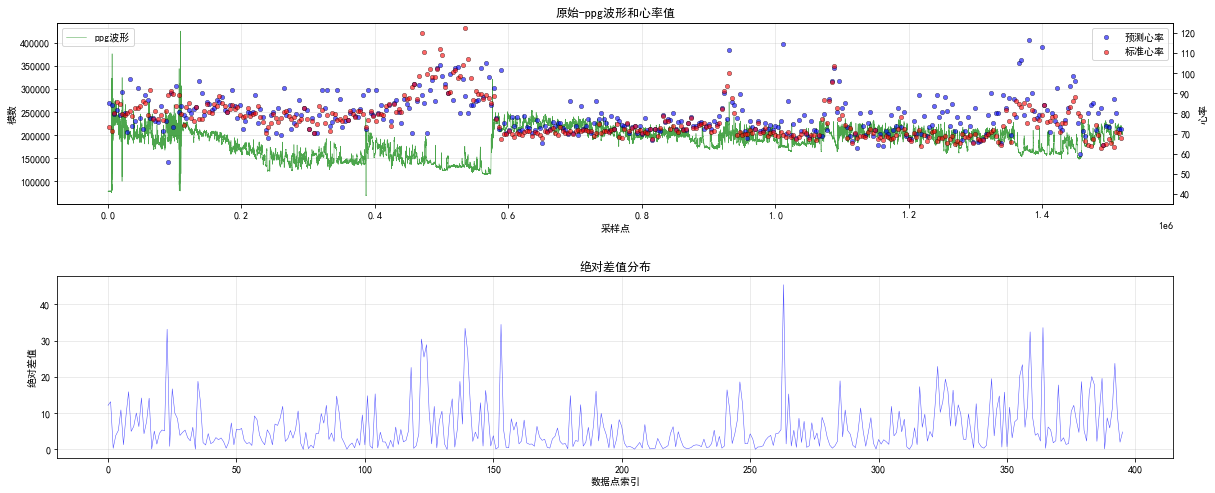

   均值  标准差  最大值  最小值  中位数  心率值个数  心率异常         [0,2]         (2,5]       (5,10]      (10,+∞)
0   6.0    6.72   45.42    0.02    3.77         396       0.0  [34.09, 135]  [25.25, 100]  [20.71, 82]  [19.95, 79]


In [8]:
# 主程序
if __name__ == "__main__":
    processor = PPGProcessor(fs=128)
    id_ori = []
    hr_ori = []
    ref_hr = []
    n = 0
    # 以30s为一段进行计算
#     cal_label = 'heart_rate_mean'
    cal_label = 'heart_rate_median'
    result_list = {}
    for i in range(0, len(ppg_phase0), 128*30):
        noisy_ppg = ppg_phase0[i:i+128*30]
        IMU_x_phase0 = IMU_X_phase0[i:i+128*30]
        IMU_y_phase0 = IMU_Y_phase0[i:i+128*30]
        IMU_z_phase0 = IMU_Z_phase0[i:i+128*30]
        results = processor.process_pipeline(noisy_ppg, IMU_x_phase0,IMU_y_phase0,IMU_z_phase0)
        if results[cal_label] is None:
            n = n + 1
            continue
        id_ori.append(i+1920)  # 以每段中间作为心率中位数的时间点
        hr_ori.append(results[cal_label])
        ref_hr.append(ref_hr_phase0[n])
        if n < 10:
            result_list[f'loop_{i}'] = results
        n = n + 1
        
    result_all = pd.DataFrame(result_list).T
    result_all.drop(columns=['heart_rate_mean','heart_rate_median'],inplace = True)
    # 评价指标
    data_ori = ppg_phase0.copy()
    list0 = id_ori.copy()
    list1 = hr_ori.copy()
    list2 = ref_hr.copy()
    # 计算统计指标
    heart_rate_state = processor.evaluate_heart_rate(list2,list1)
    heart_rate_state = pd.DataFrame(heart_rate_state)
    
    with pd.ExcelWriter('output.xlsx', engine='openpyxl') as writer:
        heart_rate_state.to_excel(writer, sheet_name='心率评价', index=False)  # sheet1
        result_all.to_excel(writer, sheet_name='过程评价', index=False)  # sheet2
    
    fig = plt.figure(figsize=(20, 8))
    
    # 定义网格：2行2列，设置高度和宽度比例
    gs = gridspec.GridSpec(2, 2, 
                           height_ratios=[1, 1],  # 第一行高度是第二行的2倍
                           width_ratios=[1, 1],   # 列宽度相同
                           hspace=0.4, wspace=0.4)  # 子图间距

    # 第一行大图：占用第一行两列
    ax1 = fig.add_subplot(gs[0, :])

    # 第二行两个小图
    ax2 = fig.add_subplot(gs[1, :])
#     ax3 = fig.add_subplot(gs[1, 1])

    # 在第一行绘制
    ax1.plot(data_ori, 'g-', alpha=0.7, linewidth=0.5, label='ppg波形')
    # ax1.set_title(f'原始-ppg波形和心率值-{heart_rate:.0f}')  # 无小数
    ax1.set_title('原始-ppg波形和心率值' ) 
    ax1.set_xlabel('采样点')
    ax1.set_ylabel('模数')

    ax1_right1 = ax1.twinx()
    ax1_right1.scatter(list0, list1, alpha=0.6, s=20, c='blue', edgecolors='black', linewidth=0.5, label='预测心率')
    ax1_right1.scatter(list0, list2, alpha=0.6, s=20, c='red', edgecolors='black', linewidth=0.5, label='标准心率')
    ax1_right1.set_ylabel('心率')
    ax1_right1.set_ylim(35, 125)

    ax1.legend(loc='upper left')  # 自动选择最佳位置
    ax1_right1.legend(loc='upper right') 
    ax1.grid(True, alpha=0.3)

    # 左图: 绝对差值折线
    df_exploded = heart_rate_state.explode('差值')
#   print(df_exploded['差值'])
    ax2.plot(list(df_exploded['差值']), 'b-', alpha=0.7, linewidth=0.5)
    ax2.set_xlabel('数据点索引')
    ax2.set_ylabel('绝对差值')
    ax2.set_title('绝对差值分布')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 输出结果
    
    # 设置pandas显示选项，修复中文对齐
    pd.set_option('display.unicode.east_asian_width', True)
    pd.set_option('display.expand_frame_repr', False)  # 禁用换行显示
    pd.set_option('display.width', 0)  # 自动检测终端宽度
    print(heart_rate_state.drop(columns=['差值']))
 

## ppg数据缩放查看

In [1]:
# 缩放数据查看
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

def plot_signal_interactive_full(signal, title, ylabel, sampling_rate=128, 
                                 show_range_slider=True, show_modebar=True):
    """
    完整的交互式信号绘图函数
    
    参数:
    - show_range_slider: 是否显示范围滑块
    - show_modebar: 是否显示模式栏（缩放、保存等按钮）
    """
    # 创建时间轴
    time_seconds = np.arange(len(signal)) / sampling_rate
    time_min_sec = [f"{int(t//60)}:{t%60:05.2f}" for t in time_seconds]
    
    # 创建图表
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=time_seconds,
        y=signal,
        mode='lines',
        name=ylabel,
        line=dict(color='blue', width=2),
        hovertemplate=(
            '<b>时间</b>: %{customdata}<br>' +
            '<b>秒数</b>: %{x:.3f}s<br>' +
            f'<b>{ylabel}</b>: %{{y:.4f}}<br>' +
            '<extra></extra>'
        ),
        customdata=time_min_sec
    ))
    
    # 设置布局
    fig.update_layout(
        title={
            'text': f'<b>{title}</b>',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 20}
        },
        xaxis_title="Time (seconds)",
        yaxis_title=ylabel,
        hovermode='x unified',
        template='plotly_white',
        height=500,
        width=900,
        margin=dict(l=50, r=50, t=80, b=50)
    )
    
    # 添加范围滑块
    if show_range_slider:
        fig.update_layout(
            xaxis=dict(
                rangeslider=dict(
                    visible=True,
                    thickness=0.05,
                    bgcolor="lightgray"
                ),
                range=[0, min(30, len(signal)/sampling_rate)]  # 默认显示前30秒
            )
        )
    
    # 显示图表
    fig.show(config={
        'modeBarButtonsToAdd': ['drawline', 'drawopenpath', 'eraseshape'],
        'displayModeBar': show_modebar,
        'scrollZoom': True
    })
    
    return fig


fig = plot_signal_interactive_full(
    ppg_phase0,
    'PPG信号 - 手腕',
    '幅度 (a.u.)',
    sampling_rate=128
)
